In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from common import auxiliary
from db import hvacDBMapping

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML

In [2]:
thermafuser_df = pd.read_csv('thermafuser_readings.csv', low_memory=False, index_col=False)
thermafuser_df = thermafuser_df.drop('Unnamed: 0', axis=1)
thermafuser_df = thermafuser_df.loc[thermafuser_df['_thermafuserId'] == 1]
thermafuser_df.reset_index(inplace=True, drop=True)

In [3]:
thermafuser_df.head()

,_thermafuserId,_roomOccupied,_supplyAir,_timestamp,_occupiedCoolingSetpoint,_terminalLoad,_zoneTemperature,_airflowFeedback,_occupiedHeatingSetpoint
0,1,True,75.199997,2018-07-11 14:15:00,76.0,NaN,74.699997,63.0,70.0
1,1,True,76.099998,2018-07-11 14:20:01,76.0,NaN,74.300003,61.0,70.0
2,1,True,75.900002,2018-07-11 14:25:01,76.0,NaN,74.900002,59.0,70.0
3,1,True,75.900002,2018-07-11 14:30:02,76.0,NaN,75.099998,76.0,70.0
4,1,True,75.699997,2018-07-11 14:35:04,76.0,NaN,75.599998,150.0,70.0


In [4]:
col_names = {'_roomOccupied':'RoomOccupied', '_supplyAir':'SupplyAir', 
             '_occupiedCoolingSetpoint':'OccupiedCoolingSetpoint', '_terminalLoad':'TerminalLoad', 
            '_zoneTemperature':'ZoneTemperature', '_airflowFeedback':'AirflowFeedback', 
            '_occupiedHeatingSetpoint':'OccupiedHeatingSetpoint', '_timestamp':'Timestamp'}

thermafuser_df = thermafuser_df.drop('_thermafuserId', axis=1)
thermafuser_df = thermafuser_df.rename(columns=col_names)

In [5]:
thermafuser_df['Timestamp'] = pd.to_datetime(thermafuser_df['Timestamp'])
thermafuser_df.head()

,RoomOccupied,SupplyAir,Timestamp,OccupiedCoolingSetpoint,TerminalLoad,ZoneTemperature,AirflowFeedback,OccupiedHeatingSetpoint
0,True,75.199997,2018-07-11 14:15:00,76.0,NaN,74.699997,63.0,70.0
1,True,76.099998,2018-07-11 14:20:01,76.0,NaN,74.300003,61.0,70.0
2,True,75.900002,2018-07-11 14:25:01,76.0,NaN,74.900002,59.0,70.0
3,True,75.900002,2018-07-11 14:30:02,76.0,NaN,75.099998,76.0,70.0
4,True,75.699997,2018-07-11 14:35:04,76.0,NaN,75.599998,150.0,70.0


In [6]:
thermafuser_df.describe()

,SupplyAir,OccupiedCoolingSetpoint,TerminalLoad,ZoneTemperature,AirflowFeedback,OccupiedHeatingSetpoint
count,25330.000000,25330.000000,0.0,25330.000000,25330.000000,25330.000000
mean,71.928381,76.006553,NaN,73.956816,80.868693,69.993447
std,7.626211,0.091683,NaN,1.161022,25.631663,0.091683
min,0.000000,76.000000,NaN,71.199997,0.000000,68.000000
25%,71.699997,76.000000,NaN,73.099998,76.000000,70.000000
50%,72.199997,76.000000,NaN,73.800003,78.000000,70.000000
75%,73.300003,76.000000,NaN,74.900002,82.000000,70.000000
max,77.800003,78.000000,NaN,77.800003,294.000000,70.000000


In [7]:
thermafuser_df['RoomOccupied'] = thermafuser_df['RoomOccupied'].replace({True: 1, False: 0})
thermafuser_df = thermafuser_df.drop(['OccupiedCoolingSetpoint', 'OccupiedHeatingSetpoint', 'TerminalLoad'], axis=1)
thermafuser_df.describe()

,RoomOccupied,SupplyAir,ZoneTemperature,AirflowFeedback
count,25330.0,25330.000000,25330.000000,25330.000000
mean,1.0,71.928381,73.956816,80.868693
std,0.0,7.626211,1.161022,25.631663
min,1.0,0.000000,71.199997,0.000000
25%,1.0,71.699997,73.099998,76.000000
50%,1.0,72.199997,73.800003,78.000000
75%,1.0,73.300003,74.900002,82.000000
max,1.0,77.800003,77.800003,294.000000


In [8]:
thermafuser_df = thermafuser_df.drop('RoomOccupied', axis=1)
thermafuser_df.describe()

,SupplyAir,ZoneTemperature,AirflowFeedback
count,25330.000000,25330.000000,25330.000000
mean,71.928381,73.956816,80.868693
std,7.626211,1.161022,25.631663
min,0.000000,71.199997,0.000000
25%,71.699997,73.099998,76.000000
50%,72.199997,73.800003,78.000000
75%,73.300003,74.900002,82.000000
max,77.800003,77.800003,294.000000


In [9]:
thermafuser_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25330 entries, 0 to 25329
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SupplyAir        25330 non-null  float64       
 1   Timestamp        25330 non-null  datetime64[ns]
 2   ZoneTemperature  25330 non-null  float64       
 3   AirflowFeedback  25330 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 791.7 KB


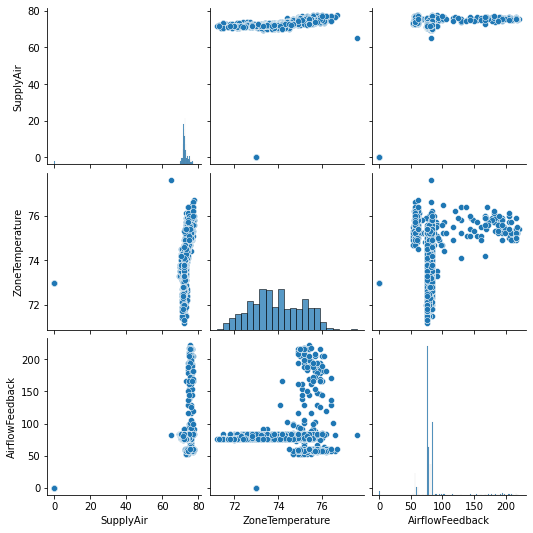

In [10]:
sampled_therma_df = thermafuser_df.sample(frac=1/10, replace=True)
#sampled_therma_df.shape
sns.pairplot(sampled_therma_df)

In [11]:
day_quarters = {0:'0-5', 1:'6-11', 2:'12-17', 3:'18-23'}
thermafuser_df['Day quarter'] = thermafuser_df['Timestamp'].map(lambda x: x.hour//6)
dummies = pd.get_dummies(thermafuser_df['Day quarter'])
thermafuser_df = pd.concat([thermafuser_df, dummies], axis=1)
thermafuser_df.rename(columns=day_quarters, inplace=True)
thermafuser_df.head()

,SupplyAir,Timestamp,ZoneTemperature,AirflowFeedback,Day quarter,0-5,6-11,12-17,18-23
0,75.199997,2018-07-11 14:15:00,74.699997,63.0,2,0,0,1,0
1,76.099998,2018-07-11 14:20:01,74.300003,61.0,2,0,0,1,0
2,75.900002,2018-07-11 14:25:01,74.900002,59.0,2,0,0,1,0
3,75.900002,2018-07-11 14:30:02,75.099998,76.0,2,0,0,1,0
4,75.699997,2018-07-11 14:35:04,75.599998,150.0,2,0,0,1,0


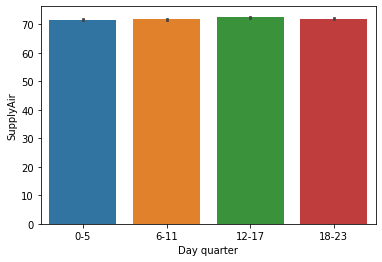

In [12]:
ax_supplyAir = sns.barplot(x='Day quarter', y='SupplyAir', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_supplyAir.get_xticks()]
_ = ax_supplyAir.set_xticklabels(xticks_labels)


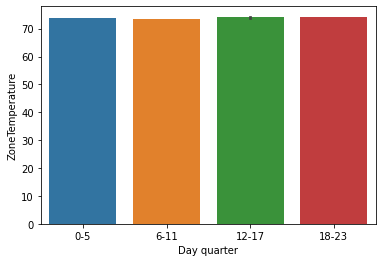

In [13]:
ax_zoneTemp = sns.barplot(x='Day quarter', y='ZoneTemperature', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_zoneTemp.get_xticks()]
_ = ax_zoneTemp.set_xticklabels(xticks_labels)

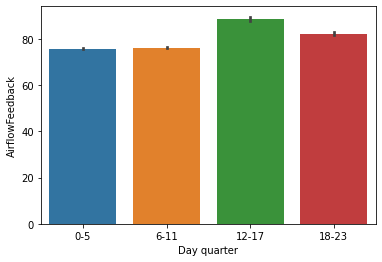

In [14]:
ax_airflowFdbck = sns.barplot(x='Day quarter', y='AirflowFeedback', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_airflowFdbck.get_xticks()]
_ = ax_airflowFdbck.set_xticklabels(xticks_labels)

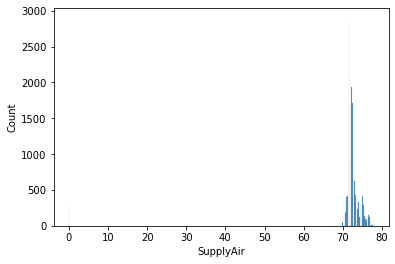

In [15]:
ax_supplyAir = sns.histplot(data=thermafuser_df, x='SupplyAir')

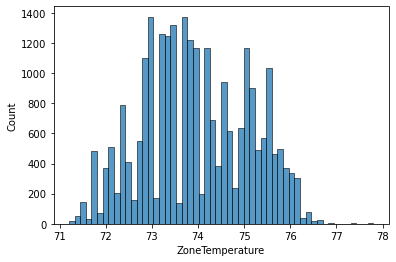

In [16]:
ax_zoneTemperature = sns.histplot(data=thermafuser_df, x='ZoneTemperature')

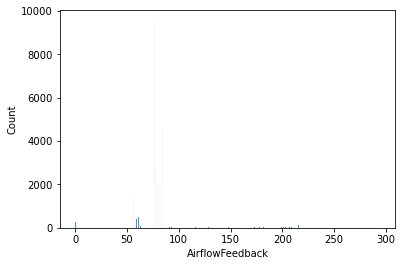

In [17]:
ax_airflowFdbck = sns.histplot(data=thermafuser_df, x='AirflowFeedback')

In [18]:
thermafuser_df.describe()

,SupplyAir,ZoneTemperature,AirflowFeedback,Day quarter,0-5,6-11,12-17,18-23
count,25330.000000,25330.000000,25330.000000,25330.000000,25330.000000,25330.00000,25330.000000,25330.000000
mean,71.928381,73.956816,80.868693,1.508962,0.247256,0.24769,0.253889,0.251165
std,7.626211,1.161022,25.631663,1.116607,0.431425,0.43168,0.435243,0.433692
min,0.000000,71.199997,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,71.699997,73.099998,76.000000,1.000000,0.000000,0.00000,0.000000,0.000000
50%,72.199997,73.800003,78.000000,2.000000,0.000000,0.00000,0.000000,0.000000
75%,73.300003,74.900002,82.000000,3.000000,0.000000,0.00000,1.000000,1.000000
max,77.800003,77.800003,294.000000,3.000000,1.000000,1.00000,1.000000,1.000000


In [19]:
print('First quarter: ' + str(thermafuser_df.loc[thermafuser_df['0-5'] == 1, ['0-5']].shape))
print('Second quarter: ' + str(thermafuser_df.loc[thermafuser_df['6-11'] == 1, ['0-5']].shape))
print('Third quarter: ' + str(thermafuser_df.loc[thermafuser_df['12-17'] == 1, ['0-5']].shape))
print('Fourth quarter: ' + str(thermafuser_df.loc[thermafuser_df['18-23'] == 1, ['0-5']].shape))

First quarter: (6263, 1)
Second quarter: (6274, 1)
Third quarter: (6431, 1)
Fourth quarter: (6362, 1)


In [20]:
thermafuser_df.drop(0, axis=0, inplace=True)
thermafuser_df.drop('Day quarter', axis=1, inplace=True)
thermafuser_df.drop('Timestamp', axis=1, inplace=True)

In [21]:
thermafuser_df.head()

,SupplyAir,ZoneTemperature,AirflowFeedback,0-5,6-11,12-17,18-23
1,76.099998,74.300003,61.0,0,0,1,0
2,75.900002,74.900002,59.0,0,0,1,0
3,75.900002,75.099998,76.0,0,0,1,0
4,75.699997,75.599998,150.0,0,0,1,0
5,76.099998,75.199997,161.0,0,0,1,0


In [38]:
X_train, X_test = train_test_split(thermafuser_df, test_size=0.1)
X_train, X_crossVal = train_test_split(X_train, test_size=0.2)

X_train.reset_index(inplace=True, drop=True)
X_crossVal.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

print(X_train.shape)
print(X_crossVal.shape)
print(X_test.shape)

X_crossVal.head()

(18236, 7)
(4560, 7)
(2533, 7)


,SupplyAir,ZoneTemperature,AirflowFeedback,0-5,6-11,12-17,18-23
0,72.400002,74.199997,80.0,0,0,0,1
1,73.000000,75.199997,78.0,1,0,0,0
2,72.099998,73.500000,84.0,0,0,0,1
3,70.800003,74.199997,78.0,0,0,1,0
4,72.099998,73.699997,82.0,1,0,0,0


In [51]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.05), max_features=1.0,
                     bootstrap=False, n_jobs=1, verbose=1)
clf.fit(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


IsolationForest(contamination=0.05, n_jobs=1, verbose=1)

In [52]:
pred = clf.predict(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback', '0-5', '6-11', '12-17', '18-23']])
X_crossVal['anomaly'] = pred
outliers = X_crossVal.loc[X_crossVal['anomaly'] == -1]
outlier_index=list(outliers.index)
print(X_crossVal['anomaly'].value_counts())

 1    4333
-1     227
Name: anomaly, dtype: int64


In [53]:
X_crossVal.head()

,SupplyAir,ZoneTemperature,AirflowFeedback,0-5,6-11,12-17,18-23,anomaly
0,72.400002,74.199997,80.0,0,0,0,1,1
1,73.000000,75.199997,78.0,1,0,0,0,1
2,72.099998,73.500000,84.0,0,0,0,1,1
3,70.800003,74.199997,78.0,0,0,1,0,1
4,72.099998,73.699997,82.0,1,0,0,0,1


In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']])

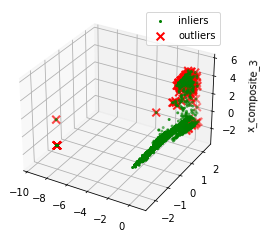

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], zs=X_scaled[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_scaled[outlier_index,0],X_scaled[outlier_index,1], X_scaled[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

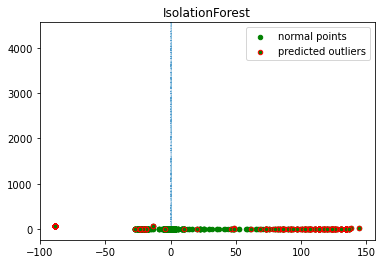

In [58]:
pca = PCA(2)
pca.fit(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']])
res=pd.DataFrame(pca.transform(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()